In [1]:
PREFIX = './fragments/Frag2/'

In [2]:
import numpy
import PIL.Image

image = numpy.array(PIL.Image.open(f"{PREFIX}/ir.png")) / 255
print(image.min(), image.max(), image.shape)

mask = numpy.array(PIL.Image.open(f"{PREFIX}/mask.png"))
print(mask.min(), mask.max(), mask.shape)

target = numpy.array(PIL.Image.open(f"{PREFIX}/inklabels.png"))
print(target.min(), target.max(), target.shape)

d:\Programs\Programming\Python\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


0.34901960784313724 1.0 (14830, 9506)
0 1 (14830, 9506)
0 1 (14830, 9506)


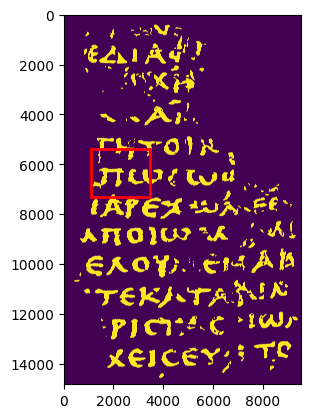

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

VAL_X = (1088, 3456)
VAL_Y = (5376, 7296)

plt.imshow(target)
plt.gca().add_patch(
    patches.Rectangle(
        (VAL_X[0], VAL_Y[0]),
        VAL_X[1] - VAL_X[0],
        VAL_Y[1] - VAL_Y[0],
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none'
    )
)

In [4]:
WINDOW = 128
HALF = (WINDOW // 2)
PADDING = (WINDOW // 4)

train_images, train_labels, train_idxs = [], [], []
test_images, test_labels, test_idxs = [], [], []
for i in range(image.shape[0] - WINDOW):
    if i % HALF != 0:
        continue
    for j in range(image.shape[1] - WINDOW):
        if j % HALF != 0:
            continue
        if mask[i][j] == 0:
            continue

        img = image[i:i + WINDOW, j:j + WINDOW]
        label = target[i:i + WINDOW, j:j + WINDOW]

        if (i > VAL_Y[0]) and (i < VAL_Y[1]) and (j > VAL_X[0]) and (j < VAL_X[1]):
            test_images.append(img)
            test_labels.append(label)
            test_idxs.append((i, j))
        else:
            train_images.append(img)
            train_labels.append(label)
            train_idxs.append((i, j))

train_images = numpy.stack(train_images)
train_labels = numpy.stack(train_labels)
test_images = numpy.stack(test_images)
test_labels = numpy.stack(test_labels)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(22802, 128, 128) (22802, 128, 128) (1037, 128, 128) (1037, 128, 128)


In [5]:
import torchvision.tv_tensors
import torchvision.transforms.v2

RESIZE_FACTOR = 2

WINDOW = WINDOW // RESIZE_FACTOR
HALF = (WINDOW // 2)
PADDING = (WINDOW // 4)

transform = torchvision.transforms.v2.Resize((WINDOW, WINDOW))

def resize(images, labels, idxs):
    images = torchvision.tv_tensors.Image(images)
    labels = torchvision.tv_tensors.Mask(labels)
    images, labels = transform(images, labels)
    idxs = [(i // RESIZE_FACTOR, j // RESIZE_FACTOR) for (i, j) in idxs]
    return images.numpy(), labels.numpy(), idxs

train_images, train_labels, train_idxs = resize(train_images, train_labels, train_idxs)
test_images, test_labels, test_idxs = resize(test_images, test_labels, test_idxs)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(22802, 64, 64) (22802, 64, 64) (1037, 64, 64) (1037, 64, 64)


In [11]:
import cvtda.topology

extractor = cvtda.topology.FeatureExtractor(only_get_from_dump = False, return_diagrams = False)
extractor = extractor.fit(train_images, f"{PREFIX}/train")
train_features = extractor.transform(train_images, f"{PREFIX}/train")
test_features = extractor.transform(test_images, f"{PREFIX}/test")

train_features.shape, test_features.shape

Calculating inverted images
GreyscaleExtractor: processing ./fragments/Frag2//train/greyscale, do_fit = True
Saving the result to ././fragments/Frag2//train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch:  11%|█         | 5/45 [00:03<00:23,  1.68it/s]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
DiagramVectorizer: batch: 100%|██████████| 45/45 [00:13<00:00,  3.22it/s]


Saving the result to ././fragments/Frag2//train/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag2//train/greyscale, do_fit = False
Got the result from ././fragments/Frag2//train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag2//train/inverted_greyscale, do_fit = True
Saving the result to ././fragments/Frag2//train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:02<00:00, 20.17it/s]


Saving the result to ././fragments/Frag2//train/inverted_greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag2//train/inverted_greyscale, do_fit = False
Got the result from ././fragments/Frag2//train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/inverted_greyscale/features.npy
Fitting filtrations
Calculated radial centers for images of size 64x64: [12 25 38 51]x[12 25 38 51]
Fitting filtration 1/72: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1, do_fit = True, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 404.37it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1/features.npy
Fitting filtration 2/72: 2/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1, do_fit = True, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 406.64it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1/features.npy
Fitting filtration 3/72: 2/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 411.30it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1/features.npy
Fitting filtration 4/72: 2/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1, do_fit = True, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 392.45it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1/features.npy
Fitting filtration 5/72: 2/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 369.09it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1/features.npy
Fitting filtration 6/72: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1, do_fit = True, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 363.11it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1/features.npy
Fitting filtration 7/72: 2/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0, do_fit = True, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 412.44it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0/features.npy
Fitting filtration 8/72: 2/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0, do_fit = True, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 409.19it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0/features.npy
Fitting filtration 9/72: 2/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_12, do_fit = True, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 405.39it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_12/features.npy
Fitting filtration 10/72: 2/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_25, do_fit = True, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 407.66it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_25/features.npy
Fitting filtration 11/72: 2/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_38, do_fit = True, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 400.70it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_38/features.npy
Fitting filtration 12/72: 2/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_51, do_fit = True, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 405.40it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_51/features.npy
Fitting filtration 13/72: 2/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_12, do_fit = True, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 405.17it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_12/features.npy
Fitting filtration 14/72: 2/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_25, do_fit = True, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 401.23it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_25/features.npy
Fitting filtration 15/72: 2/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_38, do_fit = True, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 354.34it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_38/features.npy
Fitting filtration 16/72: 2/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_51, do_fit = True, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 400.77it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_51/features.npy
Fitting filtration 17/72: 2/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_12, do_fit = True, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 398.19it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_12/features.npy
Fitting filtration 18/72: 2/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_25, do_fit = True, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 404.81it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_25/features.npy
Fitting filtration 19/72: 2/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_38, do_fit = True, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 402.53it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_38/features.npy
Fitting filtration 20/72: 2/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_51, do_fit = True, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 406.11it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_51/features.npy
Fitting filtration 21/72: 2/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_12, do_fit = True, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 414.92it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_12/features.npy
Fitting filtration 22/72: 2/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_25, do_fit = True, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 403.94it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_25/features.npy
Fitting filtration 23/72: 2/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_38, do_fit = True, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 407.42it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_38/features.npy
Fitting filtration 24/72: 2/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_51, do_fit = True, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 403.22it/s]


Saving the result to ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_51/features.npy
Fitting filtration 25/72: 4/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1, do_fit = True, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 135.54it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1/features.npy
Fitting filtration 26/72: 4/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1, do_fit = True, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 141.51it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1/features.npy
Fitting filtration 27/72: 4/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 144.69it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_-1/features.npy
Fitting filtration 28/72: 4/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_1, do_fit = True, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 144.70it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_1/features.npy
Fitting filtration 29/72: 4/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_0_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 152.03it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_0_-1/features.npy
Fitting filtration 30/72: 4/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_0_1, do_fit = True, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 154.11it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_0_1/features.npy
Fitting filtration 31/72: 4/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_0, do_fit = True, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 157.89it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_0/features.npy
Fitting filtration 32/72: 4/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_0, do_fit = True, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 160.71it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_0/features.npy
Fitting filtration 33/72: 4/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_12_12, do_fit = True, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 119.36it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_12/features.npy
Fitting filtration 34/72: 4/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_12_25, do_fit = True, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 122.28it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_25/features.npy
Fitting filtration 35/72: 4/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_12_38, do_fit = True, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 118.96it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_38/features.npy
Fitting filtration 36/72: 4/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_12_51, do_fit = True, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 118.11it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_12_51/features.npy
Fitting filtration 37/72: 4/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_25_12, do_fit = True, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 117.80it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_12/features.npy
Fitting filtration 38/72: 4/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_25_25, do_fit = True, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 122.28it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_25/features.npy
Fitting filtration 39/72: 4/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_25_38, do_fit = True, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 114.80it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_38/features.npy
Fitting filtration 40/72: 4/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_25_51, do_fit = True, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 120.00it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_25_51/features.npy
Fitting filtration 41/72: 4/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_38_12, do_fit = True, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 114.80it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_12/features.npy
Fitting filtration 42/72: 4/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_38_25, do_fit = True, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 115.09it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_25/features.npy
Fitting filtration 43/72: 4/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_38_38, do_fit = True, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 111.94it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_38/features.npy
Fitting filtration 44/72: 4/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_38_51, do_fit = True, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 115.68it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_38_51/features.npy
Fitting filtration 45/72: 4/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_51_12, do_fit = True, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 140.19it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_12/features.npy
Fitting filtration 46/72: 4/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_51_25, do_fit = True, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 124.72it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_25/features.npy
Fitting filtration 47/72: 4/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_51_38, do_fit = True, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 123.40it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_38/features.npy
Fitting filtration 48/72: 4/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/RadialFiltration_51_51, do_fit = True, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 117.80it/s]


Saving the result to ././fragments/Frag2//train/filtrations/4/RadialFiltration_51_51/features.npy
Fitting filtration 49/72: 6/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_-1, do_fit = True, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 105.63it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_-1/features.npy
Fitting filtration 50/72: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_1, do_fit = True, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 106.89it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_1/features.npy
Fitting filtration 51/72: 6/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 102.98it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_-1/features.npy
Fitting filtration 52/72: 6/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_1, do_fit = True, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 103.15it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_1/features.npy
Fitting filtration 53/72: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_0_-1, do_fit = True, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 117.77it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_0_-1/features.npy
Fitting filtration 54/72: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_0_1, do_fit = True, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 113.92it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_0_1/features.npy
Fitting filtration 55/72: 6/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_0, do_fit = True, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 112.50it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_-1_0/features.npy
Fitting filtration 56/72: 6/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_0, do_fit = True, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 109.49it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/HeightFiltrartion_1_0/features.npy
Fitting filtration 57/72: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_12_12, do_fit = True, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 85.88it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_12/features.npy
Fitting filtration 58/72: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_12_25, do_fit = True, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 83.64it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_25/features.npy
Fitting filtration 59/72: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_12_38, do_fit = True, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 86.71it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_38/features.npy
Fitting filtration 60/72: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_12_51, do_fit = True, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 85.23it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_12_51/features.npy
Fitting filtration 61/72: 6/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_25_12, do_fit = True, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 84.59it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_12/features.npy
Fitting filtration 62/72: 6/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_25_25, do_fit = True, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 81.97it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_25/features.npy
Fitting filtration 63/72: 6/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_25_38, do_fit = True, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 84.11it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_38/features.npy
Fitting filtration 64/72: 6/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_25_51, do_fit = True, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 86.54it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_25_51/features.npy
Fitting filtration 65/72: 6/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_38_12, do_fit = True, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 83.96it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_12/features.npy
Fitting filtration 66/72: 6/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_38_25, do_fit = True, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 82.42it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_25/features.npy
Fitting filtration 67/72: 6/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_38_38, do_fit = True, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 82.42it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_38/features.npy
Fitting filtration 68/72: 6/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_38_51, do_fit = True, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 87.38it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_38_51/features.npy
Fitting filtration 69/72: 6/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_51_12, do_fit = True, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 82.49it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_12/features.npy
Fitting filtration 70/72: 6/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_51_25, do_fit = True, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 81.30it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_25/features.npy
Fitting filtration 71/72: 6/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_51_38, do_fit = True, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 82.12it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_38/features.npy
Fitting filtration 72/72: 6/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/6/RadialFiltration_51_51, do_fit = True, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete


DiagramVectorizer: batch: 100%|██████████| 45/45 [00:00<00:00, 84.75it/s]


Saving the result to ././fragments/Frag2//train/filtrations/6/RadialFiltration_51_51/features.npy
Applying filtrations
Applying filtration 1/72: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1/features.npy
Applying filtration 2/72: 2/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1/features.npy
Applying filtration 3/72: 2/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1/features.npy
Applying filtration 4/72: 2/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1/features.npy
Applying filtration 5/72: 2/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1/features.npy
Applying filtration 6/72: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1/features.npy
Applying filtration 7/72: 2/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0/features.npy
Applying filtration 8/72: 2/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0/features.npy
Applying filtration 9/72: 2/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_12/features.npy
Applying filtration 10/72: 2/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_25/features.npy
Applying filtration 11/72: 2/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_38/features.npy
Applying filtration 12/72: 2/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_51/features.npy
Applying filtration 13/72: 2/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_12, do_fit = False, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_12/features.npy
Applying filtration 14/72: 2/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_25, do_fit = False, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_25/features.npy
Applying filtration 15/72: 2/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_38, do_fit = False, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_38/features.npy
Applying filtration 16/72: 2/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_51, do_fit = False, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_51/features.npy
Applying filtration 17/72: 2/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_12, do_fit = False, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_12/features.npy
Applying filtration 18/72: 2/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_25, do_fit = False, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_25/features.npy
Applying filtration 19/72: 2/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_38, do_fit = False, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_38/features.npy
Applying filtration 20/72: 2/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_51, do_fit = False, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_51/features.npy
Applying filtration 21/72: 2/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_12, do_fit = False, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_12/features.npy
Applying filtration 22/72: 2/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_25, do_fit = False, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_25/features.npy
Applying filtration 23/72: 2/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_38, do_fit = False, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_38/features.npy
Applying filtration 24/72: 2/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_51, do_fit = False, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_51/features.npy
Applying filtration 25/72: 4/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1/features.npy
Applying filtration 26/72: 4/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1/features.npy
Applying filtration 27/72: 4/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltr

GrayGeometryExtractor: 100%|██████████| 22802/22802 [03:38<00:00, 104.13it/s]


Saving the result to ././fragments/Frag2//train/geometry/features.npy
Got the result from ././fragments/Frag2//train/geometry/features.npy
Applying StandardScaler.
Calculating inverted images
GreyscaleExtractor: processing ./fragments/Frag2//train/greyscale, do_fit = False
Got the result from ././fragments/Frag2//train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag2//train/inverted_greyscale, do_fit = False
Got the result from ././fragments/Frag2//train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/inverted_greyscale/features.npy
Applying filtrations
Applying filtration 1/72: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)
Go

d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_1/features.npy
Applying filtration 3/72: 2/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_-1/features.npy
Applying filtration 4/72: 2/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_1/features.npy
Applying filtration 5/72: 2/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_-1/features.npy
Applying filtration 6/72: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_0_1/features.npy
Applying filtration 7/72: 2/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_-1_0/features.npy
Applying filtration 8/72: 2/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/HeightFiltrartion_1_0/features.npy
Applying filtration 9/72: 2/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_12/features.npy
Applying filtration 10/72: 2/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_25/features.npy
Applying filtration 11/72: 2/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_38/features.npy
Applying filtration 12/72: 2/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_12_51/features.npy
Applying filtration 13/72: 2/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_12, do_fit = False, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_12/features.npy
Applying filtration 14/72: 2/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_25, do_fit = False, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_25/features.npy
Applying filtration 15/72: 2/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_38, do_fit = False, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_38/features.npy
Applying filtration 16/72: 2/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_25_51, do_fit = False, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_25_51/features.npy
Applying filtration 17/72: 2/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_12, do_fit = False, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_12/features.npy
Applying filtration 18/72: 2/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_25, do_fit = False, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_25/features.npy
Applying filtration 19/72: 2/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_38, do_fit = False, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_38/features.npy
Applying filtration 20/72: 2/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_38_51, do_fit = False, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_38_51/features.npy
Applying filtration 21/72: 2/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_12, do_fit = False, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_12/features.npy
Applying filtration 22/72: 2/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_25, do_fit = False, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_25/features.npy
Applying filtration 23/72: 2/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_38, do_fit = False, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_38/features.npy
Applying filtration 24/72: 2/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/2/RadialFiltration_51_51, do_fit = False, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/2/RadialFiltration_51_51/features.npy
Applying filtration 25/72: 4/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_-1_-1/features.npy
Applying filtration 26/72: 4/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_1/features.npy
Applying filtration 27/72: 4/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//train/filtrations/4/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)
Got the result from ././fragments/Frag2//train/filtrations/4/HeightFiltr

DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]


Saving the result to ././fragments/Frag2//test/greyscale/features.npy
GreyscaleExtractor: processing ./fragments/Frag2//test/inverted_greyscale, do_fit = False
Saving the result to ././fragments/Frag2//test/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


Saving the result to ././fragments/Frag2//test/inverted_greyscale/features.npy
Applying filtrations
Applying filtration 1/72: 2/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 136.18it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_-1/features.npy
Applying filtration 2/72: 2/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 232.20it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_1/features.npy
Applying filtration 3/72: 2/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 170.99it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_-1/features.npy
Applying filtration 4/72: 2/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 130.89it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_1/features.npy
Applying filtration 5/72: 2/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 130.30it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_0_-1/features.npy
Applying filtration 6/72: 2/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 136.24it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_0_1/features.npy
Applying filtration 7/72: 2/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 285.09it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_-1_0/features.npy
Applying filtration 8/72: 2/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 166.63it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/HeightFiltrartion_1_0/features.npy
Applying filtration 9/72: 2/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 189.56it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_12/features.npy
Applying filtration 10/72: 2/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 236.71it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_25/features.npy
Applying filtration 11/72: 2/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 137.81it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_38/features.npy
Applying filtration 12/72: 2/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 198.22it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_12_51/features.npy
Applying filtration 13/72: 2/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_25_12, do_fit = False, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 283.23it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_12/features.npy
Applying filtration 14/72: 2/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_25_25, do_fit = False, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 172.34it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_25/features.npy
Applying filtration 15/72: 2/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_25_38, do_fit = False, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 279.91it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_38/features.npy
Applying filtration 16/72: 2/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_25_51, do_fit = False, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 129.85it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_25_51/features.npy
Applying filtration 17/72: 2/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_38_12, do_fit = False, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 135.72it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_12/features.npy
Applying filtration 18/72: 2/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_38_25, do_fit = False, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 129.81it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_25/features.npy
Applying filtration 19/72: 2/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_38_38, do_fit = False, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 124.14it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_38/features.npy
Applying filtration 20/72: 2/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_38_51, do_fit = False, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 119.90it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_38_51/features.npy
Applying filtration 21/72: 2/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_51_12, do_fit = False, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 189.27it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_12/features.npy
Applying filtration 22/72: 2/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_51_25, do_fit = False, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 111.98it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_25/features.npy
Applying filtration 23/72: 2/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_51_38, do_fit = False, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 269.18it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_38/features.npy
Applying filtration 24/72: 2/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/2/RadialFiltration_51_51, do_fit = False, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)



d:\Programs\Programming\Python\lib\site-packages\gtda\diagrams\preprocessing.py:295: RuntimeWarning: invalid value encountered in divide
  Xs[:, :, :2] /= self.scale_


Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 142.33it/s]

Saving the result to ././fragments/Frag2//test/filtrations/2/RadialFiltration_51_51/features.npy
Applying filtration 25/72: 4/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 165.19it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_-1/features.npy
Applying filtration 26/72: 4/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 134.90it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_1/features.npy
Applying filtration 27/72: 4/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 253.57it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_-1/features.npy
Applying filtration 28/72: 4/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 101.30it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_1/features.npy
Applying filtration 29/72: 4/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 193.05it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_0_-1/features.npy
Applying filtration 30/72: 4/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 122.53it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_0_1/features.npy
Applying filtration 31/72: 4/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 187.43it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_-1_0/features.npy
Applying filtration 32/72: 4/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 134.95it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/HeightFiltrartion_1_0/features.npy
Applying filtration 33/72: 4/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 164.77it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_12/features.npy
Applying filtration 34/72: 4/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 119.91it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_25/features.npy
Applying filtration 35/72: 4/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 134.92it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_38/features.npy
Applying filtration 36/72: 4/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 124.90it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_12_51/features.npy
Applying filtration 37/72: 4/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_25_12, do_fit = False, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 171.23it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_12/features.npy
Applying filtration 38/72: 4/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_25_25, do_fit = False, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 283.16it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_25/features.npy
Applying filtration 39/72: 4/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_25_38, do_fit = False, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 127.84it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_38/features.npy
Applying filtration 40/72: 4/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_25_51, do_fit = False, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 136.31it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_25_51/features.npy
Applying filtration 41/72: 4/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_38_12, do_fit = False, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 191.45it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_12/features.npy
Applying filtration 42/72: 4/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_38_25, do_fit = False, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 195.91it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_25/features.npy
Applying filtration 43/72: 4/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_38_38, do_fit = False, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 132.07it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_38/features.npy
Applying filtration 44/72: 4/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_38_51, do_fit = False, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 273.40it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_38_51/features.npy
Applying filtration 45/72: 4/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_51_12, do_fit = False, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 268.86it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_12/features.npy
Applying filtration 46/72: 4/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_51_25, do_fit = False, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 113.09it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_25/features.npy
Applying filtration 47/72: 4/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_51_38, do_fit = False, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 117.48it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_38/features.npy
Applying filtration 48/72: 4/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/4/RadialFiltration_51_51, do_fit = False, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 127.47it/s]

Saving the result to ././fragments/Frag2//test/filtrations/4/RadialFiltration_51_51/features.npy
Applying filtration 49/72: 6/HeightFiltrartion_-1_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_-1, do_fit = False, filtration = HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 55.84it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_-1/features.npy
Applying filtration 50/72: 6/HeightFiltrartion_1_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_1, do_fit = False, filtration = HeightFiltration(direction=array([1, 1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 55.44it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_1/features.npy
Applying filtration 51/72: 6/HeightFiltrartion_1_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 55.83it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_-1/features.npy
Applying filtration 52/72: 6/HeightFiltrartion_-1_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_1, do_fit = False, filtration = HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 63.68it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_1/features.npy
Applying filtration 53/72: 6/HeightFiltrartion_0_-1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_0_-1, do_fit = False, filtration = HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_0_-1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 61.40it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_0_-1/features.npy
Applying filtration 54/72: 6/HeightFiltrartion_0_1
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_0_1, do_fit = False, filtration = HeightFiltration(direction=array([0, 1]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_0_1/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 58.04it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_0_1/features.npy
Applying filtration 55/72: 6/HeightFiltrartion_-1_0
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_0, do_fit = False, filtration = HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_0/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 68.37it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_-1_0/features.npy
Applying filtration 56/72: 6/HeightFiltrartion_1_0
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_0, do_fit = False, filtration = HeightFiltration(direction=array([1, 0]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_0/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 60.90it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/HeightFiltrartion_1_0/features.npy
Applying filtration 57/72: 6/RadialFiltration_12_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_12_12, do_fit = False, filtration = RadialFiltration(center=array([12, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 60.15it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_12/features.npy
Applying filtration 58/72: 6/RadialFiltration_12_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_12_25, do_fit = False, filtration = RadialFiltration(center=array([12, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 54.45it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_25/features.npy
Applying filtration 59/72: 6/RadialFiltration_12_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_12_38, do_fit = False, filtration = RadialFiltration(center=array([12, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 47.92it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_38/features.npy
Applying filtration 60/72: 6/RadialFiltration_12_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_12_51, do_fit = False, filtration = RadialFiltration(center=array([12, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 51.26it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_12_51/features.npy
Applying filtration 61/72: 6/RadialFiltration_25_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_25_12, do_fit = False, filtration = RadialFiltration(center=array([25, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 47.11it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_12/features.npy
Applying filtration 62/72: 6/RadialFiltration_25_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_25_25, do_fit = False, filtration = RadialFiltration(center=array([25, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 45.49it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_25/features.npy
Applying filtration 63/72: 6/RadialFiltration_25_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_25_38, do_fit = False, filtration = RadialFiltration(center=array([25, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 57.19it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_38/features.npy
Applying filtration 64/72: 6/RadialFiltration_25_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_25_51, do_fit = False, filtration = RadialFiltration(center=array([25, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 53.88it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_25_51/features.npy
Applying filtration 65/72: 6/RadialFiltration_38_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_38_12, do_fit = False, filtration = RadialFiltration(center=array([38, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 57.59it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_12/features.npy
Applying filtration 66/72: 6/RadialFiltration_38_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_38_25, do_fit = False, filtration = RadialFiltration(center=array([38, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 46.76it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_25/features.npy
Applying filtration 67/72: 6/RadialFiltration_38_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_38_38, do_fit = False, filtration = RadialFiltration(center=array([38, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 58.19it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_38/features.npy
Applying filtration 68/72: 6/RadialFiltration_38_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_38_51, do_fit = False, filtration = RadialFiltration(center=array([38, 51]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 51.26it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_38_51/features.npy
Applying filtration 69/72: 6/RadialFiltration_51_12
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_51_12, do_fit = False, filtration = RadialFiltration(center=array([51, 12]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_12/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 44.00it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_12/features.npy
Applying filtration 70/72: 6/RadialFiltration_51_25
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_51_25, do_fit = False, filtration = RadialFiltration(center=array([51, 25]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_25/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 59.63it/s]

Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_25/features.npy
Applying filtration 71/72: 6/RadialFiltration_51_38
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_51_38, do_fit = False, filtration = RadialFiltration(center=array([51, 38]), n_jobs=-1)


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_38/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 54.44it/s]


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_38/features.npy
Applying filtration 72/72: 6/RadialFiltration_51_51
FiltrationExtractor: processing ./fragments/Frag2//test/filtrations/6/RadialFiltration_51_51, do_fit = False, filtration = RadialFiltration(center=array([51, 51]), n_jobs=-1)
Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_51/diagrams.npy
Applying Scaler to persistence diagrams.


DiagramVectorizer: batch: 100%|██████████| 3/3 [00:00<00:00, 48.10it/s]


Saving the result to ././fragments/Frag2//test/filtrations/6/RadialFiltration_51_51/features.npy


GrayGeometryExtractor: 100%|██████████| 1037/1037 [00:09<00:00, 103.76it/s]


Saving the result to ././fragments/Frag2//test/geometry/features.npy
Applying StandardScaler.


((22802, 7353), (1037, 7353))

In [12]:
import cvtda.segmentation

cvtda.segmentation.segment(
    train_images, train_features, train_labels,
    test_images, test_features, test_labels,
    dump_name = f"{PREFIX}/predictions", remove_cross_maps = True
)

Trying no - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x0000020DA1E89600>
Parameters: 42163945


100%|██████████| 100/100 [22:56<00:00, 13.77s/it, loss=486, lr=1e-5, Accuracy=0.815, AUC-ROC=0.5, Precision=0, Recall=0, F1-score=0, Jaccard score=0] 


Saving the result to ././fragments/Frag2//predictions/no.npy
{'model': 'Без признаков', 'Accuracy': 0.8145006818044841, 'AUC-ROC': 0.5, 'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Jaccard score': 0.0}
Trying images - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x0000020DA1E89720>
Parameters: 42163945


100%|██████████| 100/100 [40:21<00:00, 24.22s/it, loss=103, lr=1e-5, Accuracy=0.945, AUC-ROC=0.978, Precision=0.921, Recall=0.769, F1-score=0.838, Jaccard score=0.722] 


Saving the result to ././fragments/Frag2//predictions/images.npy
{'model': 'Без топологических признаков', 'Accuracy': 0.9449939635818466, 'AUC-ROC': 0.9778789018176325, 'Precision': 0.9209803179926995, 'Recall': 0.7694925106419703, 'F1-score': 0.8384487998146912, 'Jaccard score': 0.7218354211858494}
Trying topological - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x0000020DA1E89B40>
Parameters: 42163945


100%|██████████| 100/100 [1:07:01<00:00, 40.22s/it, loss=60.6, lr=1e-5, Accuracy=0.95, AUC-ROC=0.982, Precision=0.93, Recall=0.793, F1-score=0.856, Jaccard score=0.748] 


Saving the result to ././fragments/Frag2//predictions/topological.npy
{'model': 'Только топологические признаки', 'Accuracy': 0.9504928956726133, 'AUC-ROC': 0.9820364798398517, 'Precision': 0.9295123655993932, 'Recall': 0.7932703656979534, 'F1-score': 0.8560041853037769, 'Jaccard score': 0.748258144223264}
Trying combined - <cvtda.segmentation.MiniUnet.MiniUnet object at 0x0000020DA1E89780>
Parameters: 42237673


100%|██████████| 100/100 [53:48<00:00, 32.29s/it, loss=68.1, lr=1e-5, Accuracy=0.955, AUC-ROC=0.981, Precision=0.937, Recall=0.814, F1-score=0.871, Jaccard score=0.771] 


Saving the result to ././fragments/Frag2//predictions/combined.npy
{'model': 'Комбинированные признаки', 'Accuracy': 0.9552582287397541, 'AUC-ROC': 0.9807620167809797, 'Precision': 0.9366811429706662, 'Recall': 0.813816920034826, 'F1-score': 0.8709372251669796, 'Jaccard score': 0.7713806925357046}


,model,Accuracy,AUC-ROC,Precision,Recall,F1-score,Jaccard score
0,Без признаков,0.814501,0.500000,0.000000,0.000000,0.000000,0.000000
1,Без топологических признаков,0.944994,0.977879,0.920980,0.769493,0.838449,0.721835
2,Только топологические признаки,0.950493,0.982036,0.929512,0.793270,0.856004,0.748258
3,Комбинированные признаки,0.955258,0.980762,0.936681,0.813817,0.870937,0.771381


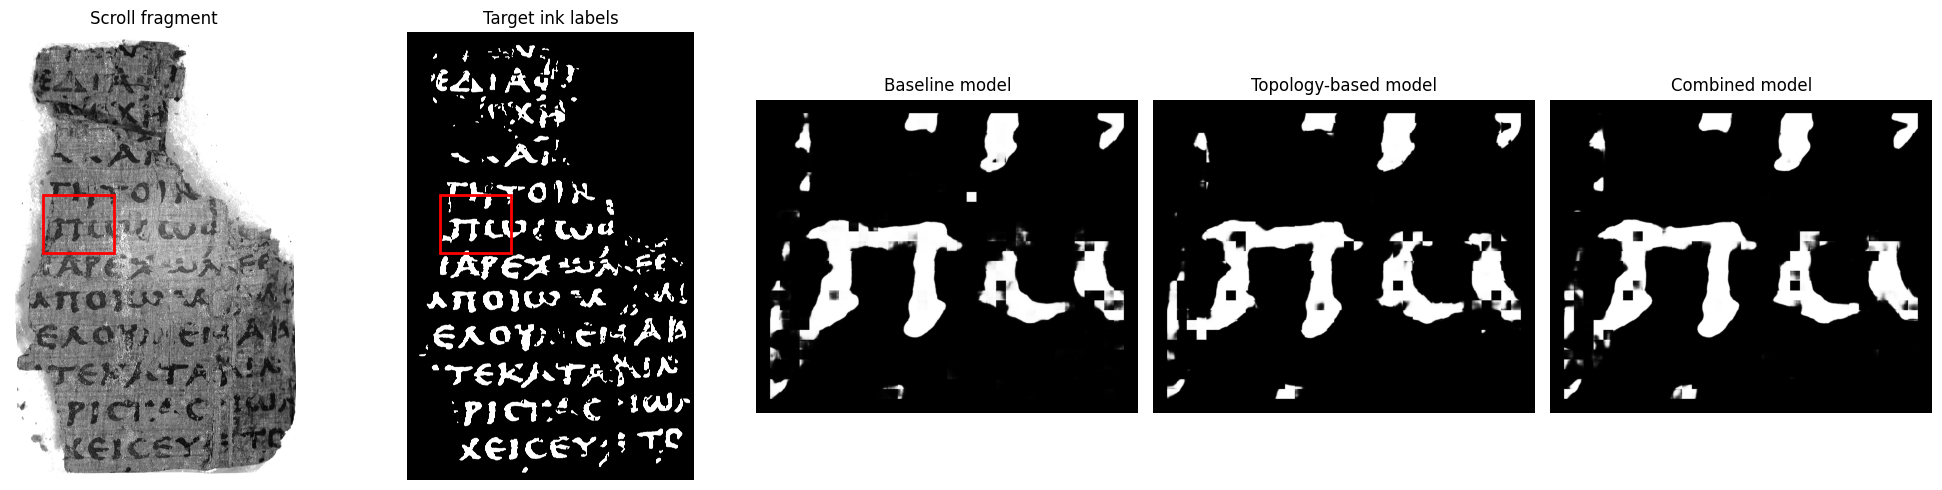

In [13]:
import numpy
import matplotlib.pyplot as plt

def restore(imgs, idxs, ax):
    restored = numpy.zeros((image.shape[0] // RESIZE_FACTOR, image.shape[1] // RESIZE_FACTOR))

    x0, x1, y0, y1 = 1e9, 0, 1e9, 0
    for img, (i, j) in zip(imgs, idxs):
        i_from, i_to = i + PADDING, i + WINDOW - PADDING
        j_from, j_to = j + PADDING, j + WINDOW - PADDING
        img_part = img[PADDING:-PADDING, PADDING:-PADDING]
        restored[i_from:i_to, j_from:j_to] = img_part

        x0, x1 = min(x0, i_from), max(x1, i_to)
        y0, y1 = min(y0, j_from), max(y1, j_to)

    diff = min((int)((x1 - x0) * 0.05), (int)((y1 - y0) * 0.05))
    ax.imshow(restored[x0 - diff:x1 + diff, y0 - diff:y1 + diff], cmap = 'gray')

fig, axes = plt.subplots(1, 5, figsize = (20, 5))

axes[0].axis('off')
axes[0].set_title("Scroll fragment")
axes[0].imshow(image, cmap = 'gray')
axes[0].add_patch(patches.Rectangle((VAL_X[0], VAL_Y[0]), VAL_X[1] - VAL_X[0], VAL_Y[1] - VAL_Y[0], linewidth = 2, edgecolor = 'r', facecolor = 'none'))

axes[1].axis('off')
axes[1].set_title("Target ink labels")
axes[1].imshow(target, cmap = 'gray')
axes[1].add_patch(patches.Rectangle((VAL_X[0], VAL_Y[0]), VAL_X[1] - VAL_X[0], VAL_Y[1] - VAL_Y[0], linewidth = 2, edgecolor = 'r', facecolor = 'none'))

axes[2].axis('off')
axes[2].set_title("Baseline model")
restore(numpy.squeeze(numpy.load(f'{PREFIX}/predictions/images.npy')), test_idxs, axes[2])

axes[3].axis('off')
axes[3].set_title("Topology-based model")
restore(numpy.squeeze(numpy.load(f'{PREFIX}/predictions/topological.npy')), test_idxs, axes[3])

axes[4].axis('off')
axes[4].set_title("Combined model")
restore(numpy.squeeze(numpy.load(f'{PREFIX}/predictions/combined.npy')), test_idxs, axes[4])

fig.tight_layout()
fig.savefig(f"{PREFIX}/predictions/display.svg")